# Exemple de diferiti algoritmi de ML pentru rezolvarea unei probleme de clasificare

Predictia tipului de tesut (normal sau patologic) pe baza caracteristicilor MaxIP si Area

Proces:
- Se pleaca de la un set de date format din masuratorile bioelectrice asociate unor probe de tesut mamar  si etichetele asociate lor
- se aleg anumite caracteristici dintre aceste masuratori (drept variabile independente) precum MaxIP si Area
- Se aplica algoritmul de invatare pe setul de antrenament
- Se realizeaza predictii pentru noi mesaje (= se eticheteaza noi mesaje)

In [2]:
#@title run the code below for prerequisites

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from sklearn import tree
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

import csv
import matplotlib.pyplot as plt 
import os
import io
import requests
import pandas as pd


def loadData(fileName, featureNames, outputVariabName):
    data = []
    dataNames = []
    csv_reader = csv.reader(fileName, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            dataNames = row
        else:
            data.append(row)
        line_count += 1
    inputs = []
    for i in range(len(data)):
        crtExample = []
        for feature in featureNames:
            selectedVariable = dataNames.index(feature)
            crtExample.append(data[i][selectedVariable])
        inputs.append(crtExample)
        
    selectedOutput = dataNames.index(outputVariabName)
    outputs = []
    for i in range(len(data)):
        outputs.append(data[i][selectedOutput])
    
    return inputs, outputs


def fromStringToNumericData(values):
    if isinstance(values[0], list):
        aux = []
        for i in range(len(values)):
            line = []
            for j in range(len(values[i])):
                line.append(float(values[i][j]))
            aux.append(line)
        return aux
    else:
        aux = []
        for i in range(len(values)):
            aux.append(float(values[i]))
        return aux

def getFeature(data, pos):
    values = []
    for i in range(len(data)):
        values.append(data[i][pos])
    return values

def plotHistograms(inputs, outputs):
    noFeatures = len(inputs[0])
    fig, ax = plt.subplots(1, noFeatures + 1,  figsize=(4 * (noFeatures + 1), 4))
    for i in range(noFeatures):
        crtFeatureValues = getFeature(inputs, i)
        ax[i].hist(crtFeatureValues, 10, color = 'r')
        ax[i].title.set_text('histogram of ' + featureNames[i])
    ax[noFeatures].hist(outputs, 10, color = 'g')
    ax[noFeatures].title.set_text('histogram of ' + outputName)

    plt.show()


def plotClassificationData(inputs, outputs, featureNames):
    noExamples = len(inputs)
    labels = set(outputs)
    noData = len(inputs)
    for crtLabel in labels:
        x = [inputs[i][0] for i in range(noExamples) if outputs[i] == crtLabel ]
        y = [inputs[i][1] for i in range(noExamples) if outputs[i] == crtLabel ]
        plt.scatter(x, y, label = crtLabel)
    plt.xlabel(featureNames[0])
    plt.ylabel(featureNames[1])
    plt.legend()
    plt.show()  


def plotPredictions(feature1, feature2, realOutputs, computedOutputs, title, featureNames, labels):
    noData = len(feature1)
    for crtLabel in labels:
        x = [feature1[i] for i in range(noData) if realOutputs[i] == crtLabel and computedOutputs[i] == crtLabel ]
        y = [feature2[i] for i in range(noData) if realOutputs[i] == crtLabel and computedOutputs[i] == crtLabel]
        plt.scatter(x, y, label = crtLabel + ' (correct)')
    for crtLabel in labels:
        x = [feature1[i] for i in range(noData) if realOutputs[i] == crtLabel and computedOutputs[i] != crtLabel ]
        y = [feature2[i] for i in range(noData) if realOutputs[i] == crtLabel and computedOutputs[i] != crtLabel]
        plt.scatter(x, y, label = crtLabel + ' (incorrect)')
    plt.xlabel(featureNames[0])
    plt.ylabel(featureNames[1])
    plt.legend()
    plt.title(title)
    plt.show()
       
def plotADecisionTree(clf):
  n_nodes = clf.tree_.node_count
  children_left = clf.tree_.children_left
  children_right = clf.tree_.children_right
  feature = clf.tree_.feature
  threshold = clf.tree_.threshold

  node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
  is_leaves = np.zeros(shape=n_nodes, dtype=bool)
  stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
  while len(stack) > 0:
      # `pop` ensures each node is only visited once
      node_id, depth = stack.pop()
      node_depth[node_id] = depth

      # If the left and right child of a node is not the same we have a split
      # node
      is_split_node = children_left[node_id] != children_right[node_id]
      # If a split node, append left and right children and depth to `stack`
      # so we can loop through them
      if is_split_node:
          stack.append((children_left[node_id], depth + 1))
          stack.append((children_right[node_id], depth + 1))
      else:
          is_leaves[node_id] = True

  # print("The binary tree structure has {n} nodes and has "
  #       "the following tree structure:\n".format(n=n_nodes))
  # for i in range(n_nodes):
  #     if is_leaves[i]:
  #         print("{space}node={node} is a leaf node.".format(
  #             space=node_depth[i] * "\t", node=i))
  #     else:
  #         print("{space}node={node} is a split node: "
  #               "go to node {left} if X[:, {feature}] <= {threshold} "
  #               "else to node {right}.".format(
  #                   space=node_depth[i] * "\t",
  #                   node=i,
  #                   left=children_left[i],
  #                   feature=feature[i],
  #                   threshold=threshold[i],
  #                   right=children_right[i]))
          
  tree.plot_tree(clf)
  plt.show()


print("setup is ready...")

setup is ready...


## Inspectare date

In [3]:
#@title run the code below to inspect the raw data

url = 'http://www.cs.ubbcluj.ro/~lauras/test/docs/docum/breastCancerBin.csv'
r = requests.get(url)
filePath = io.StringIO(r.text)

dataCrt = pd.read_csv(filePath)
dataCrt.head()

,Case#,Class,I0,PA500,HFS,DA,Area,A/DA,MaxIP,DR,P
0,1,pathological,524.794072,0.187448,0.032114,228.800228,6843.598481,29.910803,60.204880,220.737212,556.828334
1,2,pathological,330.000000,0.226893,0.265290,121.154201,3163.239472,26.109202,69.717361,99.084964,400.225776
2,3,pathological,551.879287,0.232478,0.063530,264.804935,11888.391830,44.894903,77.793297,253.785300,656.769449
3,4,pathological,380.000000,0.240855,0.286234,137.640111,5402.171180,39.248524,88.758446,105.198568,493.701813
4,5,pathological,362.831266,0.200713,0.244346,124.912559,3290.462446,26.342127,69.389389,103.866552,424.796503


## Specificarea problemei
- stabilirea caracteristicilor (date de intrare) - MaxIP si Area
- stabilirea valorilor care trebuie prezise (date de iesire) - tipul de tesut (normal sau patologic)

In [4]:
#@title run the code below for setting the input data and the output data
# first use case: predict the type of tissue (connective, adipose, glandular, carcinoma, fibro-adenoma, mastopathy) based on MaxIP and Area
noFeatures = 2
featureNames = ['MaxIP', 'Area']
outputName = 'Class'

print('A prediction model of ', outputName, ' (cancer type) based on ', featureNames, ' will be prepared...')

A prediction model of  Class  (cancer type) based on  ['MaxIP', 'Area']  will be prepared...


## Incarcarea si auditarea datelor

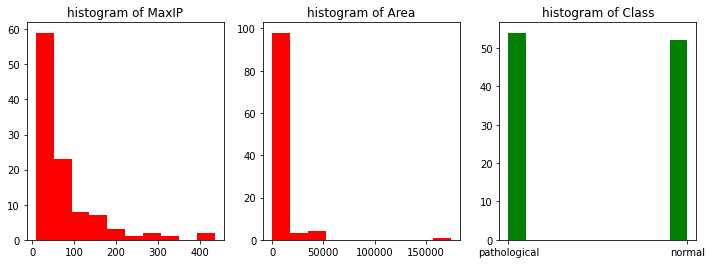

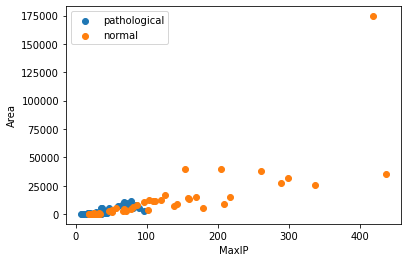

In [ ]:
#@title run the code below for loading and auditing the data

url = 'http://www.cs.ubbcluj.ro/~lauras/test/docs/docum/breastCancerBin.csv'
r = requests.get(url)
filePath = io.StringIO(r.text)


inputs, outputs = loadData(filePath, featureNames, outputName)
inputs = fromStringToNumericData(inputs)

# audit the data
plotHistograms(inputs, outputs)
if (noFeatures == 2):
    plotClassificationData(inputs, outputs, featureNames)

## Clasificare folosind metoda celui mai apropiat vecin

### Antrenarea unui model de predictie

In [ ]:
#@title run the code below for training the classifier; the training error will be printed

# try another value for the no of neighbours (parameter n_neighbors)
classifier = KNeighborsClassifier(n_neighbors=5)

classifier.fit(inputs, outputs)
computedOutputs = classifier.predict(inputs)
error = 1 - accuracy_score(outputs, computedOutputs)
print("classification training error: ", error)


classification training error:  0.2735849056603774


### Utilizarea unui model de predictie

In [ ]:
#@title run the code below from preparing sone testing data

# normal, pathological, normal
testData = [[59.5, 280.5], [61, 3039.5], [60, 305]]

computed labels:     ['normal' 'pathological' 'pathological']
ground truth labels: ['normal', 'pathological', 'normal']


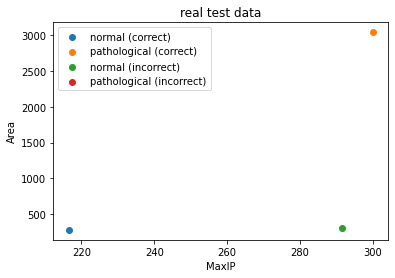

In [ ]:
#@title run the code below for predicting the tissue type for previous prepared data

predictions = classifier.predict(testData)
print('computed labels:    ', predictions)
print('ground truth labels: [\'normal\', \'pathological\', \'normal\']')
if (noFeatures == 2):
    plotPredictions([216.5, 300, 291.5], [280.5, 3039.5, 305], ['normal', 'pathological', 'normal'], predictions, "real test data", featureNames, ['normal', 'pathological'])

## Clasificare folosind arbori de decizie

### Antrenarea unui model de predictie

classification training error:  0.17924528301886788


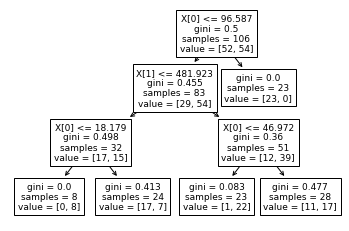

In [ ]:
#@title run the code below for training the classifier; the training error will be printed

# please try another value for the depth of the tree (max_depth parameter)
classifier = DecisionTreeClassifier(max_depth = 3, random_state=0)

classifier.fit(inputs, outputs)
computedOutputs = classifier.predict(inputs)
error = 1 - accuracy_score(outputs, computedOutputs)
print("classification training error: ", error)

plotADecisionTree(classifier)

### Utilizarea unui model de predictie

In [ ]:
#@title run the code below from preparing sone testing data

# normal, pathological, normal
testData = [[59.5, 280.5], [61, 3039.5], [60, 305]]

computed labels:     ['normal' 'pathological' 'normal']
ground truth labels: ['normal', 'pathological', 'normal']


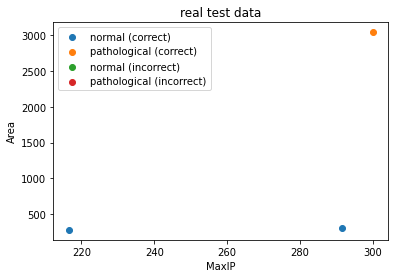

In [ ]:
#@title run the code below for predicting the tissue type for previous prepared data

predictions = classifier.predict(testData)
print('computed labels:    ', predictions)
print('ground truth labels: [\'normal\', \'pathological\', \'normal\']')

if (noFeatures == 2):
    plotPredictions([216.5, 300, 291.5], [280.5, 3039.5, 305], ['normal', 'pathological', 'normal'], predictions, "real test data", featureNames, ['normal', 'pathological'])

## Clasificare folosind Masini cu suport vectorial

### Antrenarea unui model de predictie

In [ ]:
#@title run the code below for training the classifier (please be patient)
from sklearn.svm import SVC
import numpy as np 

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
X, y = np.array(inputs), np.array(outputs)

poly1_svc = SVC(kernel='poly', degree=1).fit(X, y)
poly5_svc = SVC(kernel='poly', degree=5).fit(X, y)


computedOutputs1 = poly1_svc.predict(inputs)
error = 1 - accuracy_score(outputs, computedOutputs1)
print("classification training error (poly1): ", error)

computedOutputs5 = poly5_svc.predict(inputs)
error = 1 - accuracy_score(outputs, computedOutputs5)
print("classification training error (poly5): ", error)

6.968783379 437.0996399 69.42623881 174481.4762


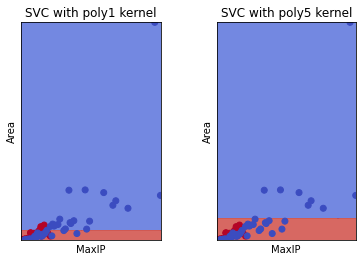

In [ ]:
#@title run the code bellow to plot the two classifications

# create a mesh to plot in
h = 10  # step size in the mesh
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
print(x_min, x_max, y_min, y_max)
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
titles =  ['SVC with poly1 kernel',
           'SVC with poly5 kernel']

y_bin = []
for el in outputs:
  if el == 'normal':
    y_bin.append(0)
  else:
    y_bin.append(1)

for i, clf in enumerate((poly1_svc, poly5_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(1, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = []
    for el in Z:
      if (el == 'normal'):
        ZZ.append([0])
      else:
        ZZ.append([1])
    ZZ = np.array(ZZ)
    # Put the result into a color plot
    ZZ = ZZ.reshape(xx.shape)
    plt.contourf(xx, yy, ZZ, cmap=plt.cm.coolwarm, alpha=0.8)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y_bin, cmap=plt.cm.coolwarm)
    plt.xlabel('MaxIP')
    plt.ylabel('Area')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])

plt.show()



### Utilizarea unui model de predictie

In [ ]:
#@title run the code below from preparing sone testing data

# normal, pathological, normal
testData = [[59.5, 280.5], [61, 3039.5], [60, 305]]

computed labels:     ['pathological' 'pathological' 'pathological']
ground truth labels: ['normal', 'pathological', 'normal']


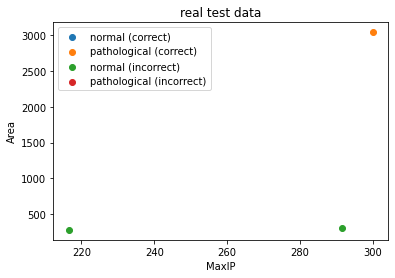

In [ ]:
#@title run the code below for predicting the tissue type for previous prepared data

predictions = poly1_svc.predict(testData)
print('computed labels:    ', predictions)
print('ground truth labels: [\'normal\', \'pathological\', \'normal\']')

if (noFeatures == 2):
    plotPredictions([216.5, 300, 291.5], [280.5, 3039.5, 305], ['normal', 'pathological', 'normal'], predictions, "real test data", featureNames, ['normal', 'pathological'])

## Clasificare folosind retele neuronale artificiale

### Antrenarea unui model de predictie

In [ ]:
#@title run the code below for training the classifier; the training error will be printed
from sklearn.neural_network import MLPClassifier

# please try another architecture
# one hidden layer with 20 neurons (20, )
# one hidden layer with 20 neurons, and another hidden layer with 10 neurons (20, 10, )
classifier = MLPClassifier((20,))

classifier.fit(inputs, outputs)
computedOutputs = classifier.predict(inputs)
error = 1 - accuracy_score(outputs, computedOutputs)
print("classification training error: ", error)


classification training error:  0.5283018867924528


### Utilizarea unui model de predictie

In [ ]:
#@title run the code below from preparing sone testing data

# normal, pathological, normal
testData = [[59.5, 280.5], [61, 3039.5], [60, 305]]

computed labels:     ['pathological' 'normal' 'pathological']
ground truth labels: ['normal', 'pathological', 'normal']


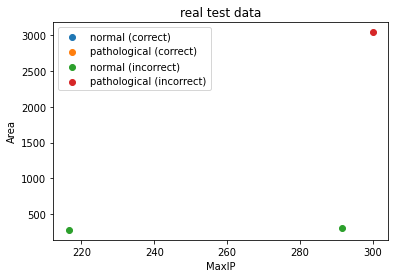

In [ ]:
#@title run the code below for predicting the tissue type for previous prepared data

predictions = classifier.predict(testData)
print('computed labels:    ', predictions)
print('ground truth labels: [\'normal\', \'pathological\', \'normal\']')

if (noFeatures == 2):
    plotPredictions([216.5, 300, 291.5], [280.5, 3039.5, 305], ['normal', 'pathological', 'normal'], predictions, "real test data", featureNames, ['normal', 'pathological'])